# Example: Basic Plots
This example demonstrate some basic plotting function.
These plots can be used to better understand the bias and where it originates from.

In this example, we will:
- use the adult dataset
- build an xgboost score over the dataset
- analyze and __visualize__ the bias of this score

## Setup
### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import pandas as pd

from fairscoring.metrics import bias_metric_pe, bias_metric_eo, bias_metric_cal
from fairscoring.plots import plot_cdf_diffs, plot_groupwise_cdfs, plot_groupwise_score_calibration
from fairscoring.plots.colors import colormap_gender_telegraph

### Loading the dataset
We load the adult dataset directly from the [uci repository](https://archive.ics.uci.edu/dataset/2/adult)

In [2]:
feature_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
                 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
                 'income']
dataURL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(dataURL, delimiter=', ', header=None, names=feature_names, engine="python")

## Model
In this example, we train an xgboost classifier to predict income ``>50K``.

This xgboost model then outputs scores for the test set that will subsequently be used for bias measures and bias plots.
### Feature Engineering
We slightly simply the input data by reducing the number of categories per feature.

In [3]:
# US-Citizen-Flag
df['native_country_bin'] = df['native_country'] == 'United-States'

In [4]:
# Numerical / Categorical Features
num_features = ['age', 'capital_gain', 'capital_loss', 'hours_per_week', 'education_num']
cat_features = ['workclass', 'education', 'marital_status', 'occupation', 'race', 'sex',
                'native_country_bin']  #'relationship'

In [5]:
# Reduce categories
df = df.replace({'workclass': {'?': 'Other/Unknown', 'Federal-gov': 'Government', 'Local-gov': 'Government',
                               'Never-worked': 'Other/Unknown', 'Private': 'Private', 'Self-emp-inc': 'Self-emp',
                               'Self-emp-not-inc': 'Self-emp', 'State-gov': 'Government',
                               'Without-pay': 'Other/Unknown'},
                 'education': {'10th': '1-12th', '11th': '1-12th', '12th': '1-12th', '1st-4th': '1-12th',
                               '5th-6th': '1-12th', '7th-8th': '1-12th', '9th': '1-12th',
                               'Assoc-acdm': 'Assoc', 'Assoc-voc': 'Assoc', 'Bachelors': 'University/College',
                               'Doctorate': 'University/College', 'HS-grad': 'HS-grad', 'Masters': 'University/College',
                               'Preschool': '1-12th', 'Prof-school': 'University/College',
                               'Some-college': 'University/College'},
                 'marital_status': {'Married-AF-spouse': 'Married', 'Married-civ-spouse': 'Married',
                                    'Married-spouse-absent': 'Married', 'Divorced': 'Div/Sep/Wid',
                                    'Separated': 'Div/Sep/Wid', 'Widowed': 'Div/Sep/Wid'},
                 'relationship': {'Husband': 'Spouse/Partner', 'Wife': 'Spouse/Partner', 'Unmarried': 'Unmarried'},
                 'occupation': {'Adm-clerical': 'White-Collar', 'Craft-repair': 'Blue-Collar',
                                'Exec-managerial': 'White-Collar', 'Farming-fishing': 'Blue-Collar',
                                'Handlers-cleaners': 'Blue-Collar', 'Machine-op-inspct': 'Blue-Collar',
                                'Other-service': 'Service', 'Priv-house-serv': 'Service',
                                'Prof-specialty': 'Professional',
                                'Protective-serv': 'Service', 'Tech-support': 'Service',
                                'Transport-moving': 'Blue-Collar', '?': 'Other/Unknown',
                                'Armed-Forces': 'Other/Unknown'}
                 })

### Encoding

In [6]:
# Store gener column
gender_column = df["sex"].copy()

In [7]:
# Encode categorical features
ordinal_enc = OrdinalEncoder().fit(df[cat_features])
df[cat_features] = ordinal_enc.transform(df[cat_features])
df[cat_features] = df[cat_features].astype(int)

In [8]:
# Undo Encoding gender
df["sex"] = gender_column
categorical = pd.get_dummies(df[cat_features].astype(str))
numerical = MinMaxScaler().fit_transform(df[num_features])
encoder = LabelEncoder()
target = encoder.fit_transform(df['income'])

### Train/Test Data
A classical train/test split with 30% test samples.

In [9]:
X = pd.concat([pd.DataFrame(categorical), pd.DataFrame(numerical)], axis=1)
X = X.rename(columns={0: 'age', 1: 'capital_gain', 2: 'capital_loss', 3: 'hours_per_week', 4: 'education_num'})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=2024)

### Train XGBoost Model
We do not focus on model quality in this example. For this reason, we omit cross validation and hyperparameter tuning.

In [11]:
xgb_model = xgb.XGBClassifier(n_estimators = 50)
xgb_model.fit(X_train, y_train)

xgb_score_test = xgb_model.predict_proba(X_test)[:,1]
xgb_score_train = xgb_model.predict_proba(X_train)[:,1]


roc_auc_test = roc_auc_score(y_test, xgb_score_test)
roc_auc_train = roc_auc_score(y_train, xgb_score_train)

print('The ROC-AUC of the XGBoost model is', roc_auc_test)
print('The train-ROC-AUC of the XGBoost model is', roc_auc_train)

The ROC-AUC of the XGBoost model is 0.922095059895014
The train-ROC-AUC of the XGBoost model is 0.942004095627337


## Fairness Metrics
### Extract core data

In [12]:
attribute = df.loc[X_test.index,"sex"]
groups = ['Female', 'Male']
favorable_target = encoder.transform([">50K"])[0]

### Bias Computation

In [13]:
results = []

for metric in [bias_metric_eo, bias_metric_pe, bias_metric_cal]:
    result = metric.bias(
                xgb_score_test, y_test, attribute,
                groups=groups,
                favorable_target=favorable_target,
                prefer_high_scores=True,
                min_score=0, max_score=1,
                n_permute=1000, seed=2579)
    results.append((metric, result))

In [14]:
data = [[metric.name, result.bias, f"{result.pos_component*100:.1f}%", f"{result.neg_component*100:.1f}%"] for metric, result in results]
df = pd.DataFrame(data, columns=["Metric", "Bias", "Pos", "Neg"])
df

,Metric,Bias,Pos,Neg
0,Equal Opportunity,0.049061,0.4%,99.6%
1,Predictive Equality,0.143191,0.0%,100.0%
2,Calibration,0.033308,57.1%,42.9%


## Calibration Plot
A calibration plot will plot the average risk (y-axis) as a function of the score (x-axis).

__Note:__
- We use the gender colormap of the telegraph
- The default setting uses bootstrapping. Set ``n_bootstrap = None`` to disable it.

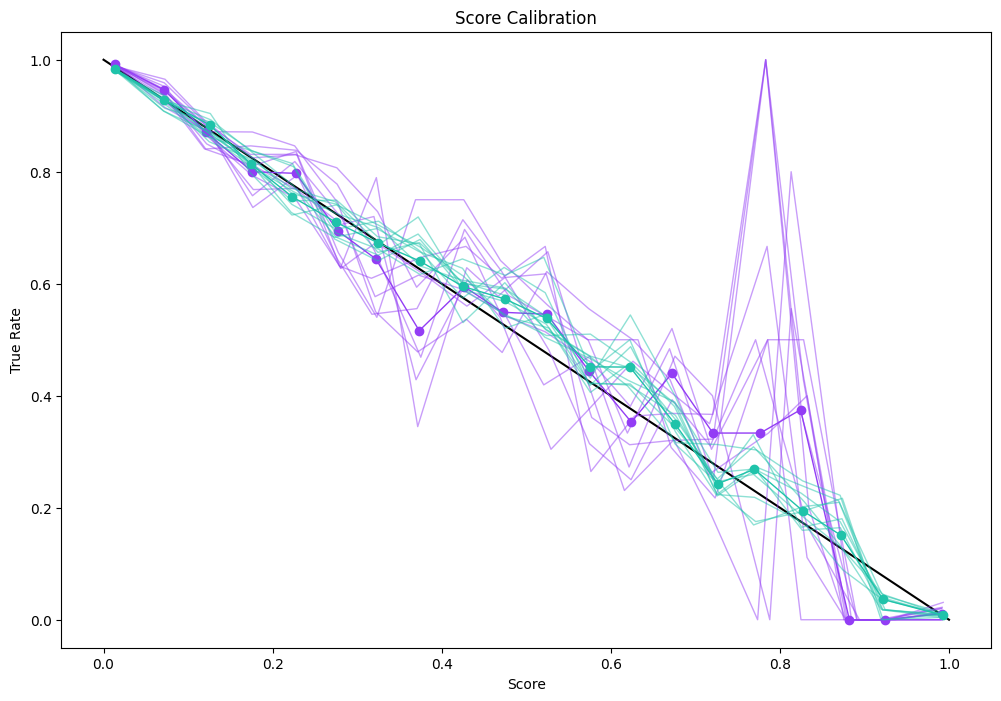

In [15]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
plot_groupwise_score_calibration(xgb_score_test, y_test, attribute, groups=groups, favorable_target=favorable_target, prefer_high_scores=True, ax=ax, palette=colormap_gender_telegraph)

## Separation Plots
- We plot both _equal opportunity_ (left) and _predcitive equality_ (right).
- The first row shows the cumulative density functions (cdfs)
- The second row shows the difference between the cdfs. The total area under the difference curve is the computed bias. Positive / Negative components correspond to areas above and below zero.


Text(0.5, 1.0, 'Predicted Equality (diff)')

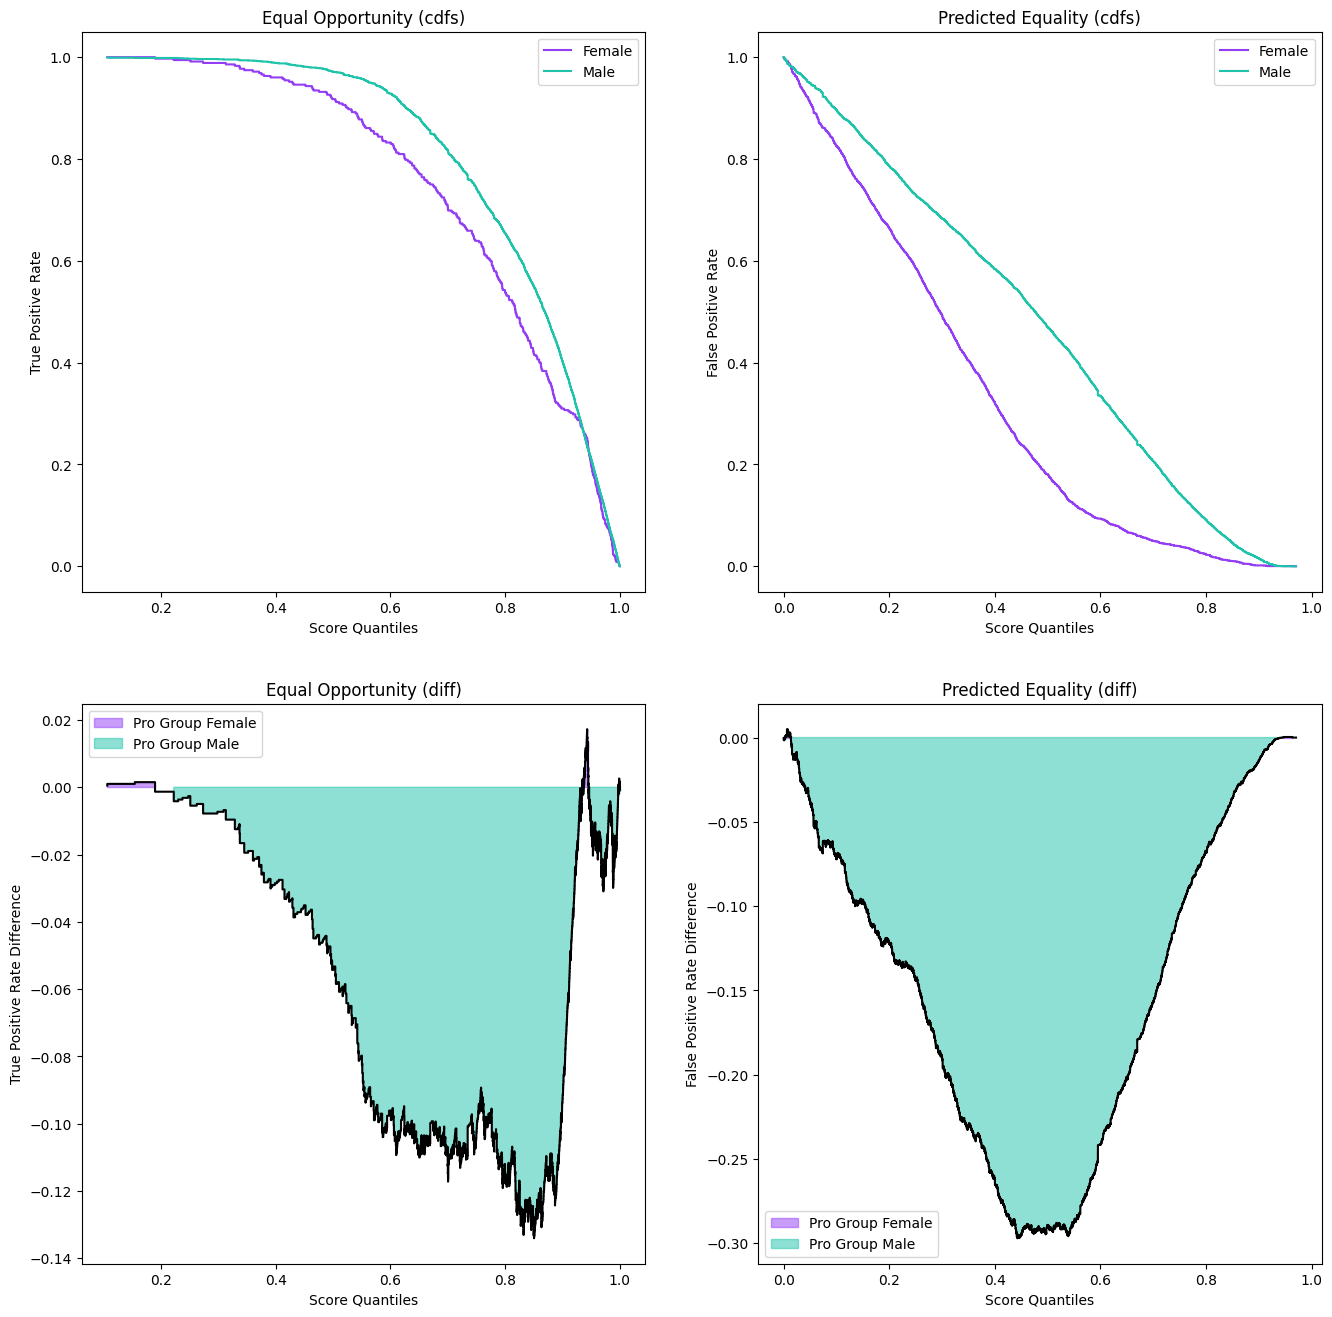

In [16]:
fig, axs = plt.subplots(2,2, figsize=(16,16))

# CDFs
plot_groupwise_cdfs(xgb_score_test, y_test, attribute, groups=groups, favorable_target=favorable_target, prefer_high_scores=True, ax=axs[0,0], fairness_type="EO", palette=colormap_gender_telegraph)
axs[0,0].set_title("Equal Opportunity (cdfs)")
plot_groupwise_cdfs(xgb_score_test, y_test, attribute, groups=groups, favorable_target=favorable_target, prefer_high_scores=True, ax=axs[0,1], fairness_type="PE", palette=colormap_gender_telegraph)
axs[0,1].set_title("Predicted Equality (cdfs)")

# Differences
plot_cdf_diffs(xgb_score_test, y_test, attribute, groups=groups, favorable_target=favorable_target, prefer_high_scores=True, ax=axs[1,0], fairness_type="EO", palette=colormap_gender_telegraph)
axs[1,0].set_title("Equal Opportunity (diff)")
plot_cdf_diffs(xgb_score_test, y_test, attribute, groups=groups, favorable_target=favorable_target, prefer_high_scores=True, ax=axs[1,1], fairness_type="PE", palette=colormap_gender_telegraph)
axs[1,1].set_title("Predicted Equality (diff)")
